# Chapter 5: Interpretable Models

In [39]:
# Imports

from preprocess_bike_data import data_pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading in the Data

In [40]:
df = data_pipeline()
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,season_SPRING,season_SUMMER,season_WINTER,holiday_NO HOLIDAY,workingday_WORKING DAY,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0,0,0,1,1,0,1,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1,0,0,1,1,0,1,0
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2,0,0,1,1,1,0,0
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3,0,0,1,1,1,0,0
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4,0,0,1,1,1,0,0


## Dropping Some Columns

In [41]:
sub_features = ['season', 'holiday','workingday', 'weathersit']
df.drop(sub_features + ['yr', 'mnth', 'weekday'], inplace=True, axis=1)

## Modeling

### Establishing Features and Target

In [42]:
features = [col for col in df.columns if col != 'cnt']
target = 'cnt'

### Linear Regression

In [43]:
import statsmodels.api as sm

model = sm.OLS(df['cnt'], df[features])
results = model.fit()
results.params

temp                           116.665202
hum                             -3.993832
windspeed                      -22.850772
days_since_2011                  5.287075
season_SPRING                  587.996465
season_SUMMER                 -237.651230
season_WINTER                 -166.550381
holiday_NO HOLIDAY            1472.214874
workingday_WORKING DAY         129.406767
weathersit_MISTY              -552.965982
weathersit_RAIN/SNOW/STORM   -2278.483205
dtype: float64

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              1851.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):                        0.00
Time:                        15:43:39   Log-Likelihood:                         -6014.8
No. Observations:                 731   AIC:                                  1.205e+04
Df Residuals:                     720   BIC:                                  1.210e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
temp                         116.6652      7.192     16.222      0.000     102.545     130.785
hum                           -3.9938      2.518     -1.586      0.113      -8.938       0.950
windspeed                    -22.8508      6.407     -3.567      0.000     -35.429     -10.273
days_since_2011                5.2871      0.169     31.303      0.000       4.955       5.619
season_SPRING                587.9965    111.794      5.260      0.000     368.515     807.478
season_SUMMER               -237.6512    137.968     -1.723      0.085    -508.519      33.217
season_WINTER               -166.5504    106.786     -1.560      0.119    -376.200      43.099
holiday_NO HOLIDAY          1472.2149    170.158      8.652      0.000    1138.150    1806.280
workingday_WORKING DAY       129.4068     75.424      1.716      0.087     -18.671     277.485
weathersit_MISTY            -552.9660     86.025     -6.428      0.000    -721.857    -384.075
weathersit_RAIN/SNOW/STORM -2278.4832    222.697    -10.231      0.000   -2715.696   -1841.271
==============================================================================
Omnibus:                       91.953   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.146
Skew:                          -0.713   Prob(JB):                     2.10e-44
Kurtosis:                       5.138   Cond. No.                     2.88e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Weight Plot

In [45]:
# Extracting and storing the coefficients and standard errors in a dictionary
coef = results.params.to_dict()
std_error = results.bse.to_dict()
conf_intervals = results.conf_int(alpha=0.5).to_dict()

In [46]:
# Converting the dictionary into Dataframe

for key, val in coef.items():
    coef[key] = [val]

t = pd.DataFrame(coef).T
t['std_error'] = t.index.map(std_error)
t.columns = ['coefficients', 'std_error']
t['lower'] = t.index.map(conf_intervals[0])
t['upper'] = t.index.map(conf_intervals[1])

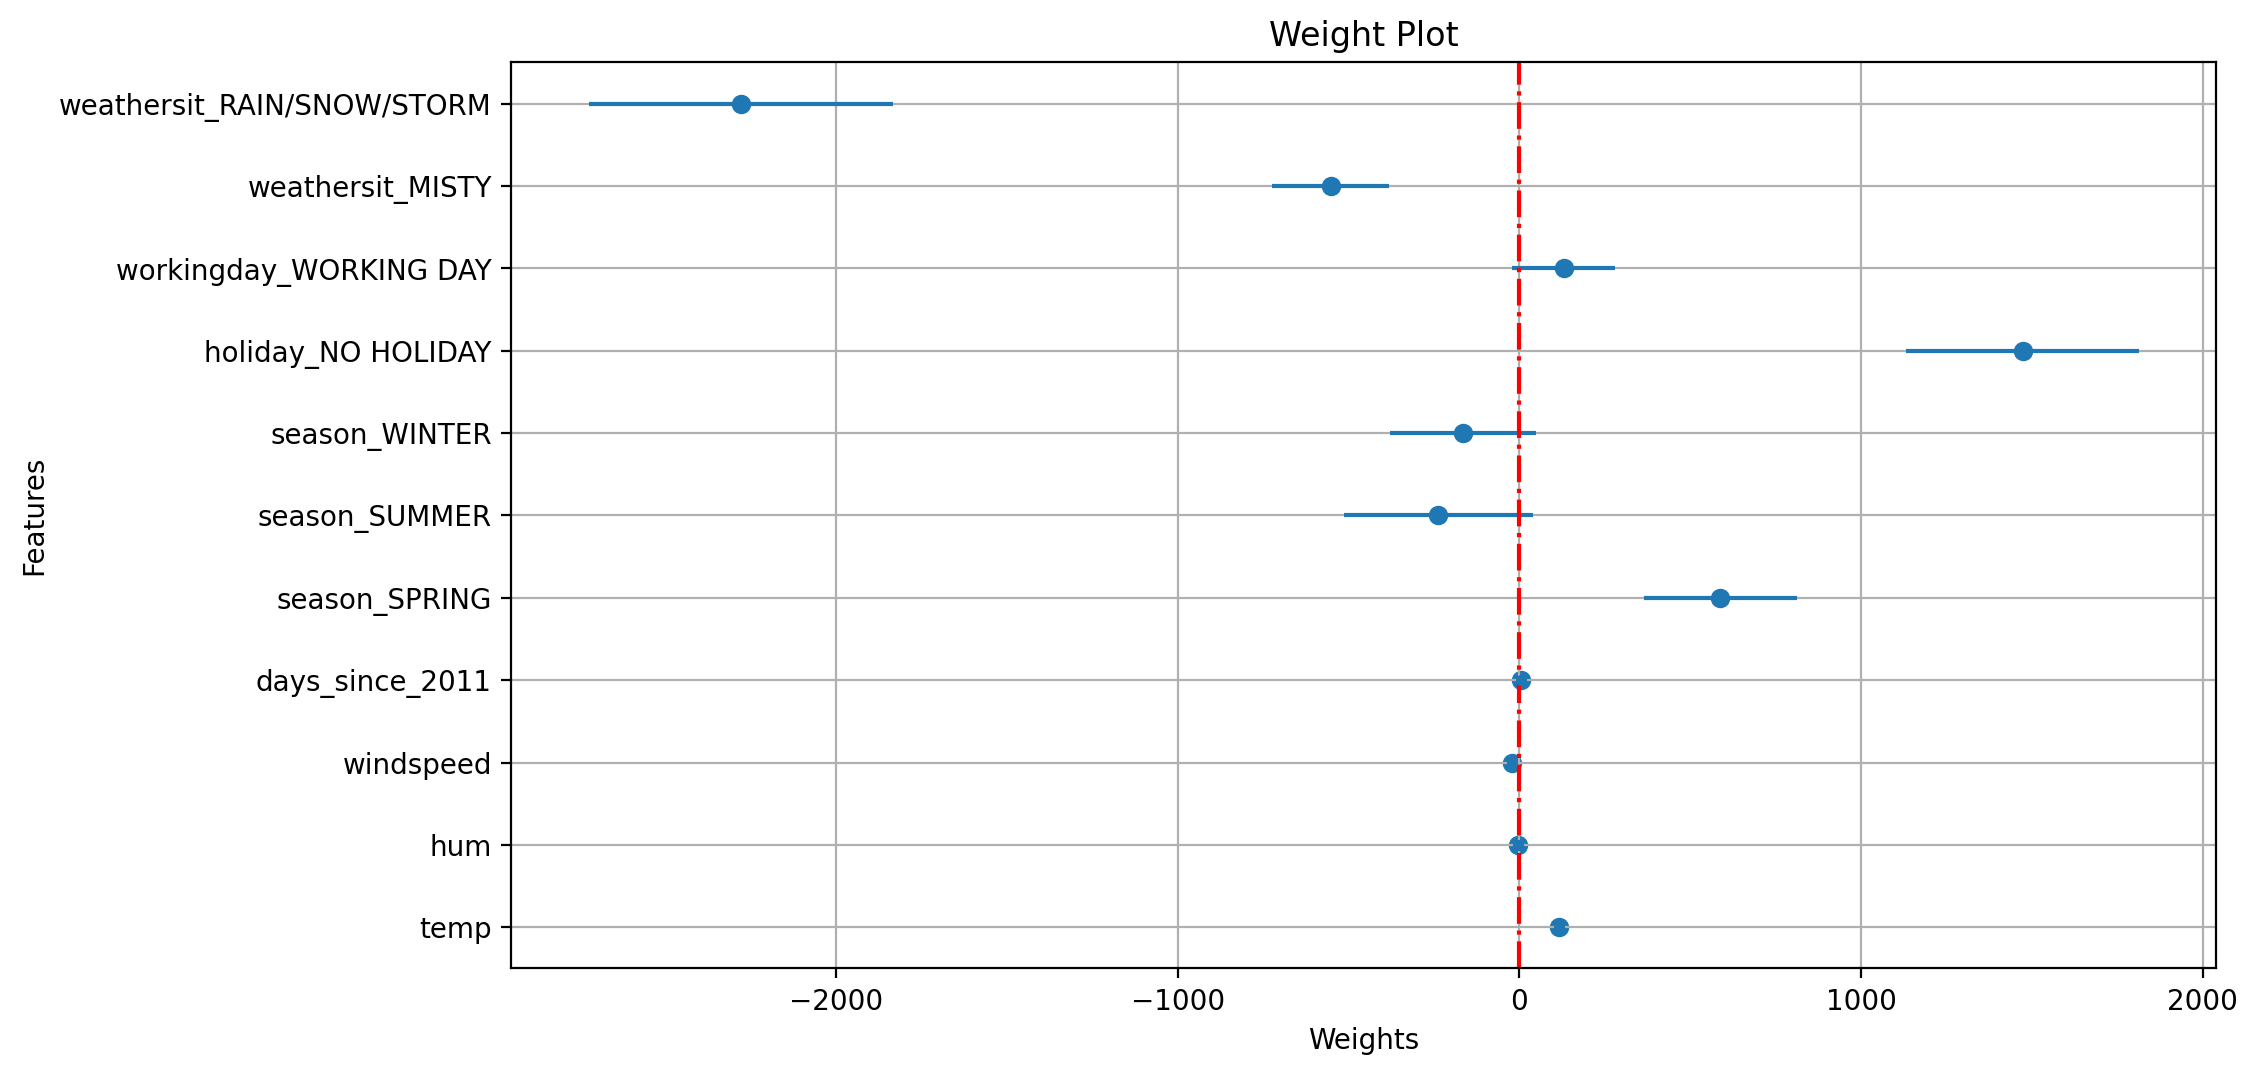

In [47]:
# Plotting the Weight Plot

plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(t['coefficients'], t.index)
ax.errorbar(t['coefficients'], t.index, xerr=2*t['std_error'], fmt = '.')
ax.axvline(0, linestyle='-.', color='red')
ax.set_title("Weight Plot")
ax.set_xlabel("Weights")
ax.set_ylabel("Features")
plt.grid('True')

The Weight Plot shows that the feature, "weathersit_RAIN/SNOW/STORM", has a strong negative effect on the bike rentals. The features, "season_WINTER", "season_SUMMER", and "workingday_WORKING DAY" have coefficients where 0 falls within its 95% confidence interval. That says that the effect is not statistically significant.

## Effect Plot
The weight plot shows how much *weight* a feature has on the prediction. BUT an effect plot helps understand how much a feature contributes to the predictions. This is done by multiplying the weight by its actual feature values. 

In [48]:
for col in [col for col in df.columns if col != 'cnt']:
    df['effect_'+col] = df[col] * coef[col][0]

In [49]:
df.head()

,temp,hum,windspeed,cnt,days_since_2011,season_SPRING,season_SUMMER,season_WINTER,holiday_NO HOLIDAY,workingday_WORKING DAY,...,effect_hum,effect_windspeed,effect_days_since_2011,effect_season_SPRING,effect_season_SUMMER,effect_season_WINTER,effect_holiday_NO HOLIDAY,effect_workingday_WORKING DAY,effect_weathersit_MISTY,effect_weathersit_RAIN/SNOW/STORM
0,8.175849,80.5833,10.749882,985,0,0,0,1,1,0,...,-321.836179,-245.643108,0.000000,0.0,-0.0,-166.550381,1472.214874,0.000000,-552.965982,-0.0
1,9.083466,69.6087,16.652113,801,1,0,0,1,1,0,...,-278.005468,-380.513645,5.287075,0.0,-0.0,-166.550381,1472.214874,0.000000,-552.965982,-0.0
2,1.229108,43.7273,16.636703,1349,2,0,0,1,1,1,...,-174.639499,-380.161515,10.574150,0.0,-0.0,-166.550381,1472.214874,129.406767,-0.000000,-0.0
3,1.400000,59.0435,10.739832,1562,3,0,0,1,1,1,...,-235.809832,-245.413457,15.861224,0.0,-0.0,-166.550381,1472.214874,129.406767,-0.000000,-0.0
4,2.666979,43.6957,12.522300,1600,4,0,0,1,1,1,...,-174.513294,-286.144228,21.148299,0.0,-0.0,-166.550381,1472.214874,129.406767,-0.000000,-0.0


In [50]:
effect_columns = [col for col in df.columns if "effect_" in col]
effect_columns

['effect_temp',
 'effect_hum',
 'effect_windspeed',
 'effect_days_since_2011',
 'effect_season_SPRING',
 'effect_season_SUMMER',
 'effect_season_WINTER',
 'effect_holiday_NO HOLIDAY',
 'effect_workingday_WORKING DAY',
 'effect_weathersit_MISTY',
 'effect_weathersit_RAIN/SNOW/STORM']

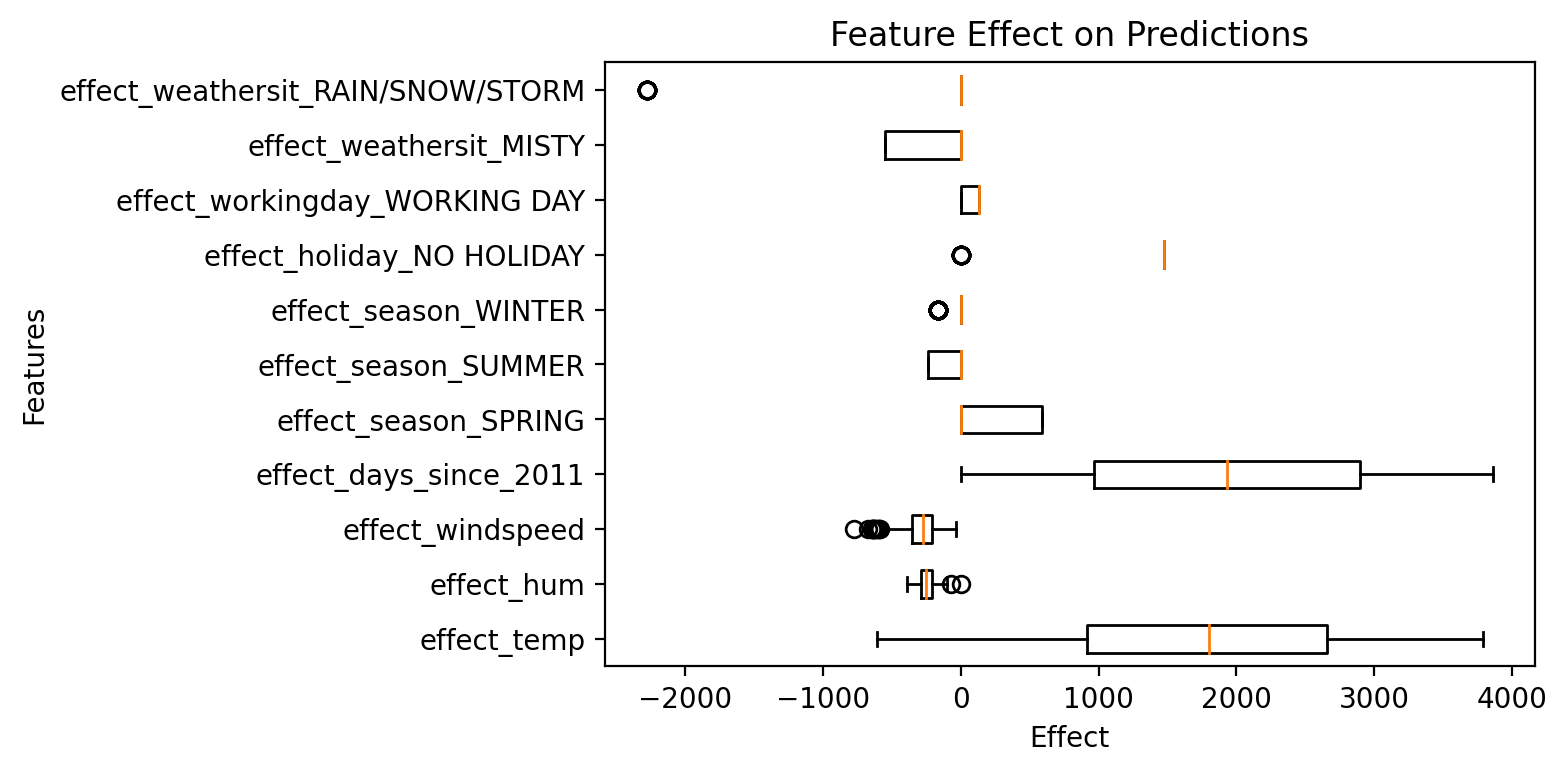

In [56]:
fig, ax = plt.subplots(1,1)

ax.boxplot(df[effect_columns], vert=False)
ax.set_yticklabels(effect_columns)
ax.set_ylabel("Features")
ax.set_xlabel("Effect")
ax.set_title("Feature Effect on Predictions");